In [1]:
import awkward as ak
import numpy as np
import hist
from coffea.nanoevents.methods import vector
from coffea.nanoevents import NanoEventsFactory, DelphesSchema, NanoAODSchema

/tmp/ipykernel_22002/2480709660.py:4: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  from coffea.nanoevents.methods import vector


In [2]:
events = NanoEventsFactory.from_root('tag_1_delphes_events.root', schemaclass=DelphesSchema).events()

In [6]:
selectedJets = events.Jet[(events.Jet.PT >= 10) & (np.abs(events.Jet.Eta) < 2.5)]
jets = selectedJets[(ak.num(selectedJets, axis=1)==4) & (ak.sum(selectedJets.BTag, axis=1)==1)\
& (ak.num(events.Muon, axis=1)==0) & (ak.num(events.Electron, axis=1)==0) & (ak.num(events.Photon, axis=1)==0)]
# jets = events.Jet[(ak.num(events.Jet, axis=1)==4) & (ak.sum(events.Jet.BTag, axis=1)==1)\
# & (ak.num(events.Muon, axis=1)==0) & (ak.num(events.Electron, axis=1)==0) & (ak.num(events.Photon, axis=1)==0)]
nonbtag = jets[jets.BTag==0]
#jets=jets[(nonbtag[:,0]+nonbtag[:,1]+nonbtag[:,2]).mass>85]
nonbtag=jets[jets.BTag==0]
nonbtag = ak.with_field(nonbtag.compute(), np.array([[1,2,3]]), "jet_index")
btag=ak.flatten(jets[jets.BTag==1].compute())

In [4]:
combined_jets = ak.combinations(nonbtag, 2, fields=['j0', 'j1'])
MW = 80.38
Mt = 173.21
mass_function = ((MW-(combined_jets.j0+combined_jets.j1).mass)**2)+\
                ((Mt-(combined_jets.j0+combined_jets.j1+btag).mass)**2)
combination_index = ak.argmin(mass_function, axis=1)
W_jets = combined_jets[np.arange(ak.num(combination_index,axis=0)),combination_index.to_numpy(allow_missing=False)]
Gluon_jet = ak.flatten(nonbtag[(nonbtag.jet_index != W_jets.j0.jet_index) & (nonbtag.jet_index != W_jets.j1.jet_index)])
W_mass = (W_jets.j0+W_jets.j1).mass
t_mass = (W_jets.j0+W_jets.j1+btag).mass
T_mass = (W_jets.j0+W_jets.j1+btag + Gluon_jet).mass

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f2ef34e3130>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

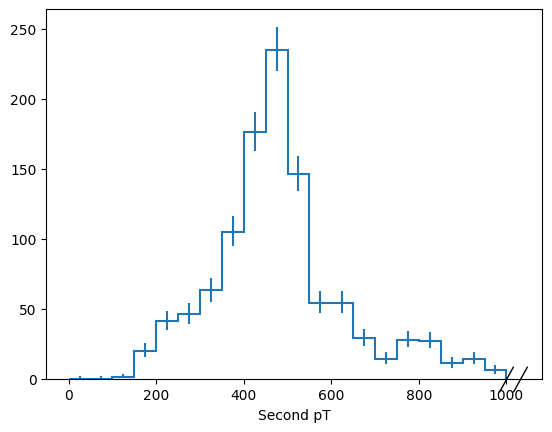

In [9]:
mass_plot = hist.Hist(hist.axis.Regular(name='pt2', label='Second pT', bins=20, start= 0, stop=1000))
#mass_plot.fill(W_mass)
#mass_plot.fill(t_mass)
mass_plot.fill(T_mass)
mass_plot.plot1d()